In [1]:
import numpy as np
from datetime import datetime
import os
import json
from pyeosim import spectral, atmosphere
from pyeosim import sensor
from pyeosim import datasets
import pysolar
import pandas as pd
import yaml
import colorcet as cc
import xarray
import matplotlib.pyplot as plt
from scipy.stats import linregress
import Py6S

def read_atmos_meta(path):
    """
    Loads JSON file containing atmospheric simulation parameters used in 6SV
    """
    jsons = os.listdir(path)
    jsons = [x for x in os.listdir(path) if x.endswith('json')]
    metas = {}
    for _json in jsons:
        with open(os.path.join(path, _json), 'r') as f:
            metas[_json.split('.')[0]] = json.load(f)
    return pd.DataFrame(metas).T
# applying spatial/spectral downsampling without sensor
def apply_spatial_spectral_downsampling(arr, sensor):
    return arr.pipe(sensor.steps[1][1]).pipe(sensor.steps[2][1],
             sensor.psf_fwhm, sensor.ground_sample_distance)
    
def sensor_correction_experiment(toa_radiance, sensor):
    """
    Performs a calibration experiment based on an input radiance dataset
    and a sensor to give the correction factors needed to convert DN
    to apparent radiance. Note that this assumes a linear relationship
    between DN and radiance.
    
    Parameters
    ----------
    toa_radiance : xarray.DataArray
        At-sensor (top-of-atmosphere) Radiance
    sensor : pyeosim.sensor.Sensor
        A valid sensor instance
    
    Returns
    -------
    calibration_coefs : xarray.Dataset
        contains the m and c parameters for linear
        model to convert DN to radiance
    """
    # applying spatial/spectral downsampling without sensor
    def apply_spatial_spectral_downsampling(arr, sensor):
        return arr.pipe(sensor.steps[1][1]).pipe(sensor.steps[2][1],
                 sensor.psf_fwhm, sensor.ground_sample_distance)
    
    # applying linear regression model
    def find_coeffs(radiance, sensor_output):
        # create vectors
        y = radiance.values.ravel()
        x = sensor_output.values.ravel()
        res = linregress(x, y)
        return res.slope, res.intercept
    
    # converting linregress coefs to xarray
    def corrections_to_xarray(corrs):
        df = pd.DataFrame(corrs).T
        m = xarray.DataArray(df[0], dims='band', name='m')
        c = xarray.DataArray(df[1], dims='band', name='c')
        return xarray.Dataset({'m':m,'c':c})
    
    # Sensor equivalent radiance
    dn = sensor.fit_transform(toa_radiance)
    L_s = apply_spatial_spectral_downsampling(toa_radiance, sensor)
    
    # iterate bands and apply linear regression to each band
    out = {}
    for i, b in enumerate(dn.band_name.values):
        out[i] = find_coeffs(L_s.isel(band=i),
                                dn.isel(band=i))

    return corrections_to_xarray(out)

def convert_to_radiance(sensor_dn, corrections):
    """
    Converts DN to apparent radiance using corrections
    in a linear model y=mx + c
    
    Parameters
    ----------
    sensor_dn : xarray.DataArray
        sensor output in DN
    corrections : xarray.Dataset
        dataset with m and c variables
    
    Returns
    -------
    sensor_radiance : xarray.DataArray
        sensor output in radiance
    """
    return (sensor_dn * corrections['m'] ) + corrections['c']


# This data is bottom of atmosphere reflectance (approximated) and so is used as starting point for simulation
surface_reflectance = xarray.open_dataset(datasets.DATA_PATHS['TEST_HSI_LARGE']).Reflectance
surface_reflectance = surface_reflectance.swap_dims({'band':'wavelength'})
# slice between 400 and 898 to reduce data volume and align with the bandpass responses used later in simulation
# Also rescale to reflectance by divide by 10000
surface_reflectance = surface_reflectance.sel(wavelength=slice(400,898)).astype(float)/10000
# replace anything with a greater than 1 reflectance by truncating at 1
surface_reflectance = surface_reflectance.where(surface_reflectance <= 1, other=1)
# Load sensor configurations
sensor_configs = yaml.load(open('sensors.yaml', 'r'), Loader=yaml.Loader)
print('Available Sensor Configurations:')
print(list(sensor_configs.keys()))

Available Sensor Configurations:
['TreeView_1_MSI_16', 'TreeView_1_MSI_32', 'TreeView_2_MSI_16', 'TreeView_2_MSI_32', 'TreeView_1_PAN_32', 'TreeView_1_PAN_64', 'TreeView_2_PAN_32', 'TreeView_2_PAN_64', 'TreeView_3_MSI_16', 'TreeView_3_MSI_32', 'TreeView_3_PAN_32', 'TreeView_3_PAN_64']


In [2]:
# Load an atmosphere for simulation
atm = atmosphere.LUT_from_file('atmospheres/atmospheres_2/')
# Use the Milton Keynes 22/6/2020, 10.30 scenario
atm.LUT = atm.LUT.isel(scenario=6)
# convert reflectance to radiance with atmospheric conversion
toa_radiance = atm.transform(surface_reflectance)
# generate a known zero region representing the masked
# region of the sensor
toa_radiance[:, 0:62, 300:362] = 0
# make a standard Teledyne Sensor instance
teledyne_msi32 = sensor.TeledyneCMOS(**sensor_configs['TreeView_3_MSI_32'])
# standard simulation run
# sensor_output = teledyne_msi32.fit_transform(toa_radiance)
# generate the correction coefficients for our simulated sensor
# to convert from instrument DN to TOA Radiance (in Wm2 nm)
corrections = sensor_correction_experiment(toa_radiance, teledyne_msi32)
corrections

<xarray.Dataset>
Dimensions:  (band: 8)
Coordinates:
  * band     (band) int64 0 1 2 3 4 5 6 7
Data variables:
    m        (band) float64 0.001913 0.001521 0.001349 ... 0.001213 0.001672
    c        (band) float64 -0.0003271 -0.001809 ... -0.0001897 -0.0002429

In [3]:
# Run a simulation
sensor_output = teledyne_msi32.transform(toa_radiance)
# Convert to radiance using Radiance = (m * DN) + c 
sensor_output_radiance = convert_to_radiance(sensor_output, corrections)
# Generate equivalent reflectance (non-normalised) and radiance downsampled to sensor spatial/spectral
sensor_equiv_reflectance = apply_spatial_spectral_downsampling(surface_reflectance, teledyne_msi32)
sensor_equiv_radiance = apply_spatial_spectral_downsampling(toa_radiance, teledyne_msi32)

In [138]:
def generate_mk_test_sixs():
    a = Py6S.SixS()

    a.ground_reflectance = Py6S.GroundReflectance.HomogeneousLambertian(1)
    a.altitudes.set_sensor_satellite_level()
    geom = Py6S.Geometry.User()
    geom.from_time_and_location(lat=52.04,
                                lon=0.76,
                                datetimestring='2020-06-22 10:30:00',
                                view_z=0,
                                view_a=0)
    a.geometry = geom
    return a



def generate_correction_LUT(six_s_instance, spectral_responses):
    """
    generate the LUT for a sensor given a parameterised SixS object
    
    Parameters
    ----------
    SixS : Py6S.SixS
        atmospheric conditions
    spectral_responses : pyeosim.spectral
        spectral response object
    """
    def get_correction_coefs(fitted_6s):
        s = fitted_6s
        # filter width
        fw = s.outputs.int_funct_filt
        # solar irradiance
        # direct solar irradiance
        Edir = s.outputs.direct_solar_irradiance * fw
        # diffuse solar irradiance
        Edif = s.outputs.diffuse_solar_irradiance * fw
#         # Environmental irradiance
        Eenv = s.outputs.environmental_irradiance * fw
        # sum for total
        E = Edir + Edif + Eenv
        # transmissivity
        # absorption transmissivity
        absorb  = s.outputs.trans['global_gas'].upward
#         absorb  = s.outputs.trans['global_gas'].total
        # scattering transmissivity
        scatter = s.outputs.trans['total_scattering'].upward
#         scatter = s.outputs.trans['total_scattering'].total
        # transmissivity (from surface to sensor)
        tau = absorb * scatter
#         tau = s.outputs.rat['optical_depth_total'].total
        # Our corrected version:
#         tau = 1 - (absorb * scatter)
        # path radiance
        Lp   = s.outputs.atmospheric_intrinsic_radiance * fw

        # correction coefficients for this configuration
        # i.e. surface_reflectance = (L - a) / b,
        #      where, L is at-sensor radiance
        a = Lp
        b = (tau * E) / np.pi
        return a, b
    
    a = []
    b = []
    raw_out = []
    srfs = spectral_responses.to_6sv().values()
    for srf in srfs:
        six_s_instance.wavelength = Py6S.Wavelength(*srf)
        six_s_instance.run()
        _a, _b = get_correction_coefs(six_s_instance)
        a.append(_a)
        b.append(_b)
        raw_out.append(six_s_instance.outputs)
        
    # convert to xarray
    a = xarray.DataArray(a, coords=[('band', np.arange(len(srfs)))])
    b = xarray.DataArray(b, coords=[('band', np.arange(len(srfs)))])
    return xarray.Dataset({'a':a, 'b':b}), raw_out

In [139]:
def elliptical_orbit_correction(doy):
    C0 = .03275104
    C1 = 59.66638337
    C2 = .96804905
    return C0 * np.cos(doy/C1) + C2

# dark region is defined spatially
dark_region_mask = xarray.zeros_like(sensor_output.isel(band=0)).astype(bool)
dark_region_mask[50:60, 50:60] = 1

In [140]:
atmos_cor = generate_mk_test_sixs()

In [141]:
coefs_cor, raw_6sv_outputs = generate_correction_LUT(atmos_cor, spectral.TreeView_3())

In [132]:
d174_c = elliptical_orbit_correction(174)
corrected = ((d174_c**2 * sensor_output_radiance) - coefs_cor['a']) / coefs_cor['b']

In [133]:
obs_df = corrected.where(~dark_region_mask).stack({'pix': ['y', 'x']}).to_dataframe(name='observed')

In [134]:
exp_df = (sensor_equiv_reflectance / bw).where(~dark_region_mask).stack({'pix': ['y', 'x']}).to_dataframe(name='expected')

In [135]:
obs_df['expected'] = exp_df['expected']

In [136]:
import seaborn

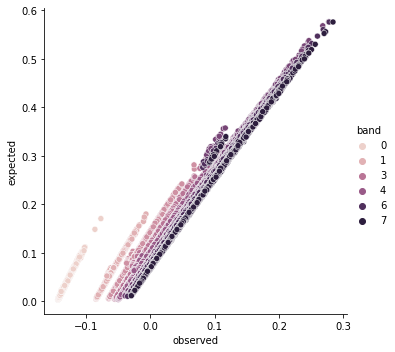

In [137]:
seaborn.relplot(data=obs_df, x='observed', y='expected', hue='band')

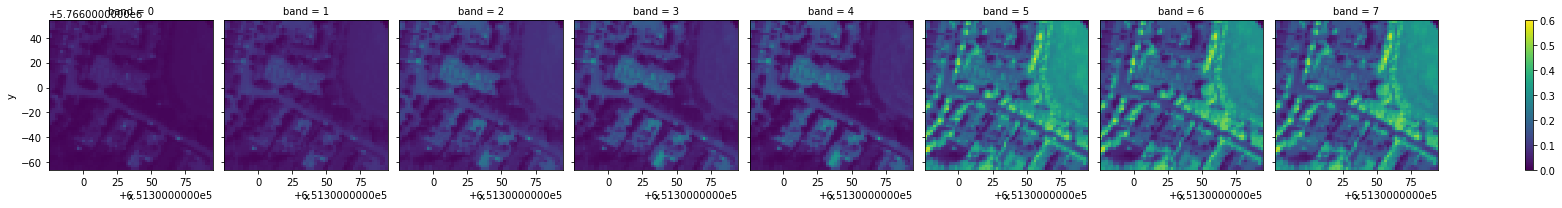

In [126]:
bw = xarray.DataArray([20, 50, 50, 40, 40, 14, 14, 30], coords={'band': np.arange(8)})
(sensor_equiv_reflectance / bw).plot(col='band',vmin=0, vmax=.6)

In [148]:
8000 * 10000 * 8 * 1e-9 * 2

1.28

In [144]:
surface_reflectance.sel(wavelength=[445], method='nearest')

<xarray.DataArray 'Reflectance' (wavelength: 1, y: 362, x: 362)>
array([[[0.0256, 0.0308, 0.0306, ..., 0.    , 0.    , 0.    ],
        [0.0335, 0.0185, 0.0177, ..., 0.    , 0.    , 0.    ],
        [0.0335, 0.0496, 0.0627, ..., 0.    , 0.    , 0.    ],
        ...,
        [0.013 , 0.0174, 0.0209, ..., 0.045 , 0.0153, 0.0103],
        [0.0144, 0.019 , 0.016 , ..., 0.0526, 0.017 , 0.0115],
        [0.0143, 0.0179, 0.0172, ..., 0.0287, 0.0139, 0.0092]]])
Coordinates:
    band        (wavelength) int64 12
  * y           (y) float64 5.766e+06 5.766e+06 ... 5.766e+06 5.766e+06
  * x           (x) float64 6.513e+05 6.513e+05 ... 6.514e+05 6.514e+05
    fwhm        (wavelength) float64 4.5
  * wavelength  (wavelength) float64 445.0

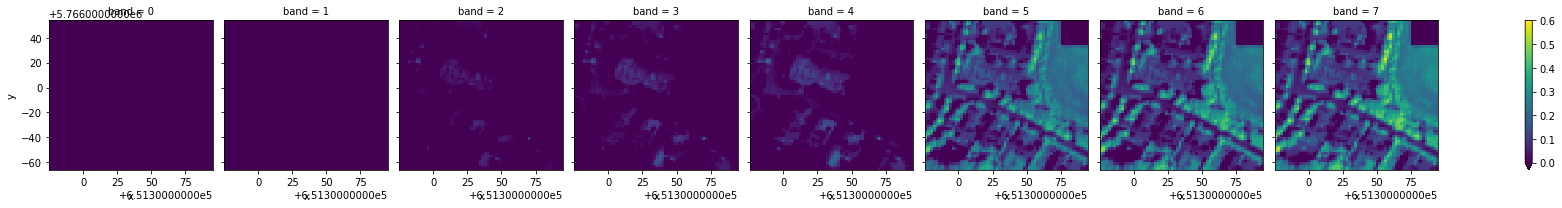

In [127]:
corrected.plot(col='band',vmin=0, vmax=.6)

In [122]:
print(raw_6sv_outputs[3])






******************************* 6SV version 1.1 *******************************
*                                                                             *
*                       geometrical conditions identity                       *
*                       -------------------------------                       *
*                       user defined conditions                               *
*                                                                             *
*   month:  6 day :  22                                                       *
*   solar zenith angle:   33.29 deg  solar azimuthal angle:      140.73 deg   *
*   view zenith angle:     0.00 deg  view azimuthal angle:         0.00 deg   *
*   scattering angle:    146.71 deg  azimuthal angle difference: 140.73 deg   *
*                                                                             *
*                       atmospheric model description                         *
*                       -----------

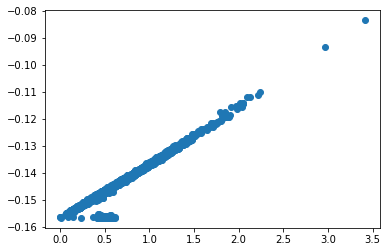

In [123]:
plt.scatter(
    sensor_equiv_reflectance.isel(band=0).values.ravel(),
    corrected.isel(band=0).values.ravel())

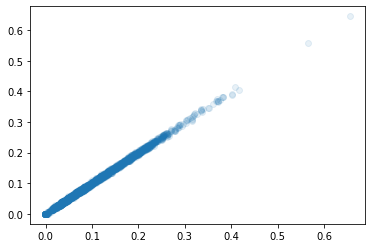

In [124]:
plt.scatter(
    sensor_output_radiance.isel(band=0).values.ravel(),
    sensor_equiv_radiance.isel(band=0).values.ravel(), alpha=.1)

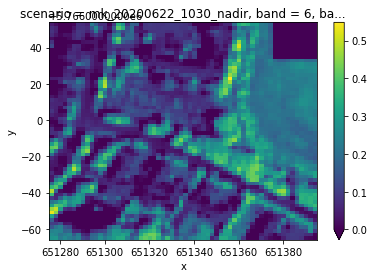

In [125]:
corrected.isel(band=6).plot(vmin=0)

In [ ]:
sol_1 = load_solar_et_spectrum('solar_irradiance/e490_00a_amo.xls')
F0 = compute_band_extraterrestrial_E(sensor.TreeView_3().srfs, sol_1 , 174)

In [ ]:
F0.plot()

In [ ]:
sensor_output_reflectance = radiance_to_reflectance(sensor_output_radiance, 33, F0)

In [ ]:
sensor_output_radiance

In [ ]:
sensor_output_radiance.plot(col='band', col_wrap=3,vmin=0)

In [ ]:
dark_region_mask.plot()

In [ ]:
df_sensor_rad = sensor_output_radiance.stack({'pix':['y', 'x']}).to_pandas().T

In [ ]:
df_sensor_ref = sensor_output_reflectance.stack({'pix':['y', 'x']}).to_pandas().T

In [ ]:
def tau(rho_ra):
    return - np.log(1 - rho_ra)

In [ ]:
plt.plot(np.linspace(0,1), tau(np.linspace(0,1)))
plt.xlabel('Reflectance')
plt.ylabel(r'$\tau$')

In [ ]:


# dark signal calculation region
dark_signal_mask = xarray.zeros_like(sensor_output.isel(band=0)).astype(bool)
dark_signal_mask[55:60, 55:60] = 1

# saturation mask
saturation_mask = sensor_output >= 2500

In [ ]:
sensor_output_reflectance.shape

In [ ]:
sensor_output_reflectance.where(~dark_region_mask).min(['y', 'x']).plot()

In [ ]:
tau(sensor_output_reflectance.quantile(q= .01, dim=['y','x'])).plot()

In [ ]:
tau(sensor_output_reflectance).isel(band=0).plot.hist(bins=100)

In [ ]:
min_signals = sensor_output.where(~dark_region_mask).min(dim=['y','x']) -1

In [ ]:
min_signals


In [ ]:
sensor_output_reflectance.sum(['band'])

In [ ]:
sensor_output_reflectance.where(~dark_region_mask).min(dim=['y','x']).plot()

In [ ]:
dark_signal = sensor_output[:,50:60, 50:60].mean(['y', 'x'])

In [ ]:
sensor_output_radiance.isel(band=6).plot(vmin=0)

In [ ]:
missing_mask.plot(col='band', col_wrap=3)

In [ ]:
saturation_mask.plot(col='band', col_wrap=3)

In [ ]:
sensor_output.where(~missing_mask).min(dim=['y','x'])

In [ ]:
atm = atmosphere.LUT_from_file('atmospheres/atmospheres_2/',)

In [ ]:
atm.LUT.s

In [ ]:
class _AtmosphericCorrection(object)

In [ ]:
atm.LUT.isel(scenario=0).interp(rho=[.1982, .2, .43334], wavelength=[493.224, 520]).drop_vars('rho')

In [ ]:
atm.LUT.where(

In [ ]:
atm.LUT.isel(scenario=0).interp(rho=[.1982, .2, .43334], wavelength=[493.224, 520]).drop_vars('rho')

In [ ]:
atm.LUT.isel(scenario=0).sel(rho=[.1982, .2, .43334], wavelength=[493.224, 520], method='nearest').drop_vars('rho')

In [ ]:
spectral.TreeView_3().to_6sv()

In [ ]:
SixSHelpers.

In [ ]:
plt.plot(wavelengths, results)

In [ ]:
from pyeosim.atmosphere import LUT

In [ ]:
LUT()

In [ ]:
from pyeosim.spectral import TreeView_3

In [ ]:
tv_bandpass = spectral.TreeView_3()

In [ ]:
import numpy as np

def convert_all_srfs(srfs):
    def convert_srf(srf):
        # converts an srf array
        def get_min_max(srf):
            wlens = srf.where(srf > 0).dropna('wavelength').wavelength
            return float(wlens.min()), float(wlens.max())
        def interp(min_wlen, max_wlen):
            return np.arange(min_wlen, max_wlen+ 2.5, 2.5)
        _min, _max = 
        wlen = interp(*get_min_max(srf))
        wlen_mi = wlen /1000
        return wlen_mi, srf.interp(wavelength=wlen)
    
    out = {}
    for name, srf in srfs.items():
        out[name] = convert_srf(srf)
    
    return out

In [ ]:
from pyeosim import _spectral

In [ ]:
_spectral._min_max(tv_bandpass.srfs['PRI_1'])

In [ ]:
convert_all_srfs(tv_bandpass.srfs)

In [ ]:
tv_bandpass.srfs['PRI_1'].where(tv_bandpass.srfs['PRI_1'] > 0).dropna('wavelength').wavelength

In [ ]:
get_min_max(tv_bandpass.srfs['PRI_1'])

In [ ]:
tv_bandpass.srfs['PRI_1']

In [ ]:
import numpy as np

def bandpass_6sv(central_wavelength, bandwidth):
    """
    Parameters
    ----------
    central_wavelength : float
        centre of bandpass in nm
    bandwidth : float
        bandwidth in nm    
    """
    min_wlen = (central_wavelength - (bandwidth/2)) / 1000
    max_wlen = (central_wavelength + (bandwidth/2)) / 1000
    wlens = np.arange(min_wlen, max_wlen+ .0025, .0025)
    return wlens, np.ones_like(wlens)

In [ ]:
def bandpass_6sv(central_wavelength, bandwidth):
    """
    Parameters
    ----------
    central_wavelength : float
        centre of bandpass in nm
    bandwidth : float
        bandwidth in nm    
    """
    min_wlen = (central_wavelength - (bandwidth/2)) / 1000
    max_wlen = (central_wavelength + (bandwidth/2)) / 1000
    wlens = np.arange(min_wlen, max_wlen+ .0025, .0025)
    return wlens, np.ones_like(wlens)

In [ ]:
spe

In [ ]:
bandpass_6sv(525, 50)


In [ ]:
def load_solar_et_spectrum(fpath):
    df = pd.read_excel(fpath)
    # convert to w m2 nm and nm for wavelength
    # wavelength is in microns in file
    wlen = df.iloc[:,0].values * 1000
    # irradiance is in w/m2/micron in file
    E = df.iloc[:,1].values / 1000
    xr = xarray.DataArray(E, coords=[('wavelength', wlen)])
    return xr.sel(wavelength=slice(100,3500))

def compute_band_extraterrestrial_E(srfs, E_0, day_of_year):
    E_is = []
    for _, srf in srfs.items():
        E_total = pysolar.radiation.get_apparent_extraterrestrial_flux(day_of_year)
        E_i = (E_0 / E_0.integrate('wavelength')) * E_total
        E_is.append(float((srf.interp_like(E_i) * E_i).fillna(0).integrate('wavelength')))
    return xarray.DataArray(E_is, coords=[('band', np.arange(len(srfs)))])

def radiance_to_reflectance(radiance, solar_z, F_0):
    return (np.pi * radiance) / (np.cos(np.deg2rad(solar_z)) * F_0)